# Tuning and Optimizing Neural Networks - Lab

## Introduction

Now that you've seen some regularization, initialization and optimization techniques, its time to synthesize those concepts into a cohesive modeling pipeline.  

With this pipeline, you will not only fit an initial model but will also attempt to set various hyperparameters for regularization techniques. Your final model selection will pertain to the test metrics across these models. This will more naturally simulate a problem you might be faced with in practice, and the various modeling decisions you are apt to encounter along the way.  

Recall that our end objective is to achieve a balance between overfitting and underfitting. You've seen the bias variance trade-off, and the role of regularization in order to reduce overfitting on training data and improving generalization to new cases. Common frameworks for such a procedure include train/validate/test methodology when data is plentiful, and K-folds cross-validation for smaller, more limited datasets. In this lab, you'll perform the latter, as the dataset in question is fairly limited. 

## Objectives

You will be able to:

* Implement a K-folds cross validation modeling pipeline
* Apply normalization as a preprocessing technique
* Apply regularization techniques to improve your model's generalization
* Choose an appropriate optimization strategy 

In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras import initializers
from keras import layers
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from keras import optimizers
from sklearn.model_selection import train_test_split


## Loading the Data

Load and preview the dataset below.

In [3]:
# Your code here; load and preview the dataset
df=pd.read_csv("loan_final.csv")
df.head()

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,total_acc,total_pymnt,application_type
0,5000.0,4975.0,36 months,10.65%,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,AZ,9.0,5863.155187,Individual
1,2500.0,2500.0,60 months,15.27%,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,GA,4.0,1014.530000,Individual
2,2400.0,2400.0,36 months,15.96%,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,IL,10.0,3005.666844,Individual
3,10000.0,10000.0,36 months,13.49%,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,CA,37.0,12231.890000,Individual
4,3000.0,3000.0,60 months,12.69%,67.79,B,1 year,RENT,80000.0,Source Verified,Fully Paid,other,OR,38.0,4066.908161,Individual


In [4]:
df.isna().sum()

loan_amnt                 3
funded_amnt_inv           3
term                      3
int_rate                  3
installment               3
grade                     3
emp_length             1115
home_ownership            3
annual_inc                7
verification_status       3
loan_status               3
purpose                   3
addr_state                3
total_acc                32
total_pymnt               3
application_type          3
dtype: int64

In [5]:
# drop rows with no label
df.dropna(subset=['total_pymnt'],inplace=True)

In [6]:
#df=df.dropna()
df.isna().sum()

loan_amnt                 0
funded_amnt_inv           0
term                      0
int_rate                  0
installment               0
grade                     0
emp_length             1112
home_ownership            0
annual_inc                4
verification_status       0
loan_status               0
purpose                   0
addr_state                0
total_acc                29
total_pymnt               0
application_type          0
dtype: int64

## Defining the Problem

Set up the problem by defining X and y. 

For this problem use the following variables for X:
* loan_amnt
* home_ownership
* funded_amnt_inv
* verification_status
* emp_length
* installment
* annual_inc

Our target variable y will be ```total_pymnt```

In [7]:
# Your code here; appropriately define X and y and apply a trian test split
X=df[['loan_amnt',
'home_ownership',
'funded_amnt_inv',
'verification_status',
'emp_length',
'installment',
'annual_inc']]

y=df['total_pymnt']

y=(y-np.mean(y))/np.std(y)

In [8]:
X.shape

(42535, 7)

In [9]:
y.shape

(42535,)

In [10]:
#X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42)
y

0       -0.676960
1       -1.210099
2       -0.991160
3        0.023327
4       -0.874469
           ...   
42533   -0.912677
42534   -1.194587
42535   -1.002284
42536   -0.510842
42537   -0.703722
Name: total_pymnt, Length: 42535, dtype: float64

## Generating a Hold Out Test Set

While we will be using K-fold cross validation to select an optimal model, we still want a final hold out test set that is completely independent of any modeling decisions. As such, pull out a sample of 10% of the total available data. For consistency of results, use random seed 123. 

In [11]:
# Your code here; generate a hold out test set for final model evaluation. Use random seed 123.

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=123)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31901 entries, 41522 to 15725
Data columns (total 7 columns):
loan_amnt              31901 non-null float64
home_ownership         31901 non-null object
funded_amnt_inv        31901 non-null float64
verification_status    31901 non-null object
emp_length             31108 non-null object
installment            31901 non-null float64
annual_inc             31897 non-null float64
dtypes: float64(4), object(3)
memory usage: 1.9+ MB


### Preprocessing Steps
* Fill in missing values with SimpleImputer
* Standardize continuous features with StandardScalar()
* One hot encode categorical features with OneHotEncoder()

In [12]:
cont_features = ['loan_amnt', 'funded_amnt_inv', 'installment', 'annual_inc']
X_train_cont= X_train[cont_features]
X_train_cat=X_train.drop(cont_features, axis=1)


In [13]:
X_train_cat

,home_ownership,verification_status,emp_length
41522,RENT,Verified,4 years
30479,RENT,Not Verified,2 years
4534,RENT,Verified,10+ years
33113,MORTGAGE,Not Verified,10+ years
40008,RENT,Verified,10+ years
...,...,...,...
7763,MORTGAGE,Verified,10+ years
15377,MORTGAGE,Verified,NaN
17730,OWN,Not Verified,5 years
28030,RENT,Not Verified,1 year


In [14]:
cat_features=[x for x in X_train_cat.columns]
cat_features

['home_ownership', 'verification_status', 'emp_length']

In [15]:
cont_features 

['loan_amnt', 'funded_amnt_inv', 'installment', 'annual_inc']

In [16]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_cont=imp_mean.fit_transform(X_train_cont)
X_train_cat=X_train_cat.fillna('missing')

In [17]:
X_train_cat

,home_ownership,verification_status,emp_length
41522,RENT,Verified,4 years
30479,RENT,Not Verified,2 years
4534,RENT,Verified,10+ years
33113,MORTGAGE,Not Verified,10+ years
40008,RENT,Verified,10+ years
...,...,...,...
7763,MORTGAGE,Verified,10+ years
15377,MORTGAGE,Verified,missing
17730,OWN,Not Verified,5 years
28030,RENT,Not Verified,1 year


In [18]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
scaler=StandardScaler()
scaler.fit_transform(X_train_cont)
X_train_cont=pd.DataFrame(scaler.fit_transform(X_train_cont), columns=cont_features)


In [19]:
X_train_cont

,loan_amnt,funded_amnt_inv,installment,annual_inc
0,-0.716277,-1.316047,-0.622372,-0.649962
1,0.252926,0.392249,0.552459,-0.585531
2,0.118314,0.255956,-0.202807,0.237043
3,-0.420131,-0.303194,-0.265850,0.155683
4,-0.689354,-0.586263,-0.610549,0.042617
...,...,...,...,...
31896,3.214378,2.436242,1.487853,0.072588
31897,-0.150909,-0.023619,-0.069638,-0.121898
31898,-0.766756,-0.663147,-0.653104,1.209178
31899,-0.648971,-0.540833,-0.480491,-0.552628


In [20]:
ohe=OneHotEncoder()
ohe.fit(X_train_cat)
X_train_ohe = ohe.transform(X_train_cat)
X_train_cat=pd.DataFrame(X_train_ohe.todense(), columns=ohe.get_feature_names(input_features=cat_features))

In [21]:
X_train_cat

,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_missing
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31896,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31897,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
31898,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
31899,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
X_train=pd.concat([X_train_cont, X_train_cat], axis=1)
X_train

,loan_amnt,funded_amnt_inv,installment,annual_inc,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,...,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_missing
0,-0.716277,-1.316047,-0.622372,-0.649962,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.252926,0.392249,0.552459,-0.585531,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.118314,0.255956,-0.202807,0.237043,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.420131,-0.303194,-0.265850,0.155683,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.689354,-0.586263,-0.610549,0.042617,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31896,3.214378,2.436242,1.487853,0.072588,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31897,-0.150909,-0.023619,-0.069638,-0.121898,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
31898,-0.766756,-0.663147,-0.653104,1.209178,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
31899,-0.648971,-0.540833,-0.480491,-0.552628,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preprocess Your Holdout Set

Make sure to use your StandardScalar and OneHotEncoder that you already fit on the training set to transform your test set

In [23]:
X_test_cont= X_test[cont_features]
X_test_cat=X_test.drop(cont_features, axis=1)

X_test=imp_mean.transform(X_test_cont)
X_test_cat=X_test_cat.fillna('missing')

#X_test_cont=scaler.transform(X_test_cont)
X_test_cont=pd.DataFrame(scaler.transform(X_test_cont), columns=cont_features)

X_test_ohe=ohe.transform(X_test_cat)
X_test_cat=pd.DataFrame(X_test_ohe.todense(), columns=ohe.get_feature_names(input_features=cat_features))

In [24]:
#X_test_cont=pd.DataFrame(X_test_cont)

In [25]:
X_test=pd.concat([X_test_cont, X_test_cat], axis=1)

In [26]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10634 entries, 0 to 10633
Data columns (total 24 columns):
loan_amnt                              10634 non-null float64
funded_amnt_inv                        10634 non-null float64
installment                            10634 non-null float64
annual_inc                             10634 non-null float64
home_ownership_MORTGAGE                10634 non-null float64
home_ownership_NONE                    10634 non-null float64
home_ownership_OTHER                   10634 non-null float64
home_ownership_OWN                     10634 non-null float64
home_ownership_RENT                    10634 non-null float64
verification_status_Not Verified       10634 non-null float64
verification_status_Source Verified    10634 non-null float64
verification_status_Verified           10634 non-null float64
emp_length_1 year                      10634 non-null float64
emp_length_10+ years                   10634 non-null float64
emp_length_2 years     

In [27]:
y_train

41522   -0.553338
30479    0.414888
4534    -1.290766
33113   -0.263407
40008   -0.592364
           ...   
7763     1.987085
15377   -0.103547
17730   -1.189076
28030   -0.439324
15725   -0.914052
Name: total_pymnt, Length: 31901, dtype: float64

## Defining a K-fold Cross Validation Methodology

Now that your have a complete holdout test set, write a function that takes in the remaining data and performs k-folds cross validation given a model object. 

> Note: Think about how you will analyze the output of your models in order to select an optimal model. This may involve graphs, although alternative approaches are certainly feasible.

In [28]:
# Your code here; define a function to evaluate a model object using K folds cross validation.

def k_folds(features_train, labels_train, model_obj, k=10, n_epochs=100):
    colors = sns.color_palette("Set2")

    validation_scores = []
    
    kf = KFold(n_splits=10, shuffle=True)
    
    fig, axes = plt.subplots(2, 5, figsize=(12,8))
    for i, (train_index, test_index) in enumerate(kf.split(features_train)):
        "Currently graph imaging assumes 10 folds and is hardcoded to 5x2 layout."
        
        row = i//5
        col = i%5
        
        X_train, X_val = features_train.iloc[train_index], features_train.iloc[test_index]
        y_train, y_val = labels_train.iloc[train_index], labels_train.iloc[test_index]
        
        model = model_obj
        
        hist = model.fit(X_train, y_train, batch_size=32,
                         epochs=n_epochs, verbose=0, validation_data = (X_val, y_val))
        #Note: verboxe=0 turns off printouts regarding training for each epoch.
        #Potential simpler methodology
        validation_score = model.evaluate(X_val, y_val)
        validation_scores.append(validation_score)
        ax = axes[row, col]
        k = 'val_loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[0])

        k = 'loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[1])
        ax.set_title('Fold {} Validation'.format(i+1))
        
    #Final Graph Formatting
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.legend(bbox_to_anchor=(1,1))
    
    #General Overview
    validation_score = np.average(validation_scores)
    print('Mean Validation Score:', validation_score)
    print('Standard Deviation of Validation Scores:', np.std(validation_scores))
    return validation_score


X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31901 entries, 0 to 31900
Data columns (total 24 columns):
loan_amnt                              31901 non-null float64
funded_amnt_inv                        31901 non-null float64
installment                            31901 non-null float64
annual_inc                             31901 non-null float64
home_ownership_MORTGAGE                31901 non-null float64
home_ownership_NONE                    31901 non-null float64
home_ownership_OTHER                   31901 non-null float64
home_ownership_OWN                     31901 non-null float64
home_ownership_RENT                    31901 non-null float64
verification_status_Not Verified       31901 non-null float64
verification_status_Source Verified    31901 non-null float64
verification_status_Verified           31901 non-null float64
emp_length_1 year                      31901 non-null float64
emp_length_10+ years                   31901 non-null float64
emp_length_2 years     

## Building a Baseline Model

Here, it is also important to define your evaluation metric that you will look to optimize while tuning the model. Additionally, model training to optimize this metric may consist of using a validation and test set if data is plentiful, or k-folds cross-validation if data is limited. Since this dataset is not overly large, it will be most appropriate to set up a k-folds cross-validation  

In [29]:
import time
import datetime

now = datetime.datetime.now()

input_dim = X_train.shape[1]

from keras.models import Sequential

from keras.layers import Dense# Your code here; define and compile an initial model as described


np.random.seed(123)
model = Sequential()
model.add(Dense(8,input_dim=input_dim,  kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))

model.compile(optimizer='sgd' ,loss='mse',metrics=['mse'])

## Evaluating the Baseline Model with K-Folds Cross Validation

Use your k-folds function to evaluate the baseline model.  

Note: This code block is likely to take 10-20 minutes to run depending on the specs on your computer.
Because of time dependencies, it can be interesting to begin timing these operations for future reference.

Here's a simple little recipe to achieve this:
```
import time
import datetime

now = datetime.datetime.now()
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)
```

3190/3190 [==============================] - 0s 22us/step
Mean Validation Score: 0.18424165336154813
Standard Deviation of Validation Scores: 0.009545644999503961


0.18424165336154813

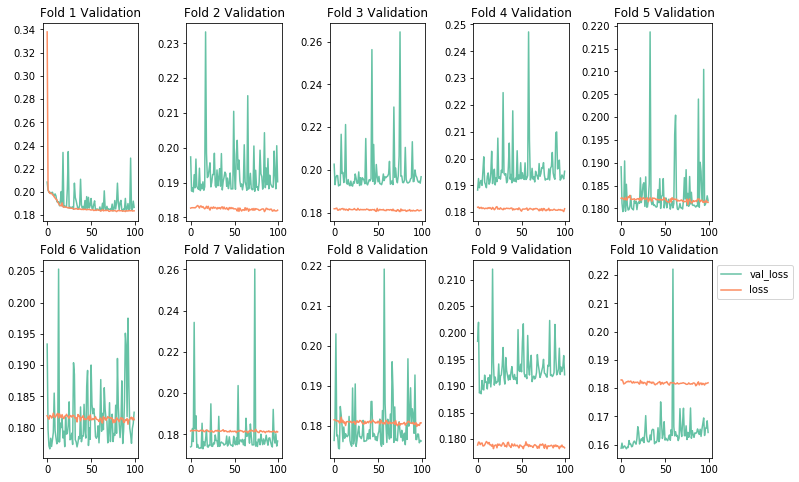

In [498]:
# Your code here; use your k-folds function to evaluate the baseline model.
# ⏰ This cell may take several mintes to run
import seaborn as sns
import matplotlib.pyplot as plt
k_folds(X_train, y_train, model)

## Intentionally Overfitting a Model

Now that you've developed a baseline model, its time to intentionally overfit a model. To overfit a model, you can:
* Add layers
* Make the layers bigger
* Increase the number of training epochs

Again, be careful here. Think about the limitations of your resources, both in terms of your computers specs and how much time and patience you have to let the process run. Also keep in mind that you will then be regularizing these overfit models, meaning another round of experiments and more time and resources.

In [502]:
# Your code here; try some methods to overfit your network
# ⏰ This cell may take several mintes to run
now = datetime.datetime.now()
input_dim = X_train.shape[1]
np.random.seed(123)
model = Sequential()
model.add(Dense(8,input_dim=input_dim,  kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))

model.compile(optimizer='sgd' ,loss='mse',metrics=['mse'])

elapsed = later - now
print('Time Elapsed:', elapsed)


Time Elapsed: -1 day, 23:59:58.348819


3190/3190 [==============================] - 0s 21us/step
Mean Validation Score: 0.1848894625429136
Standard Deviation of Validation Scores: 0.020013517976890167
Time Elapsed: 0:19:39.800372


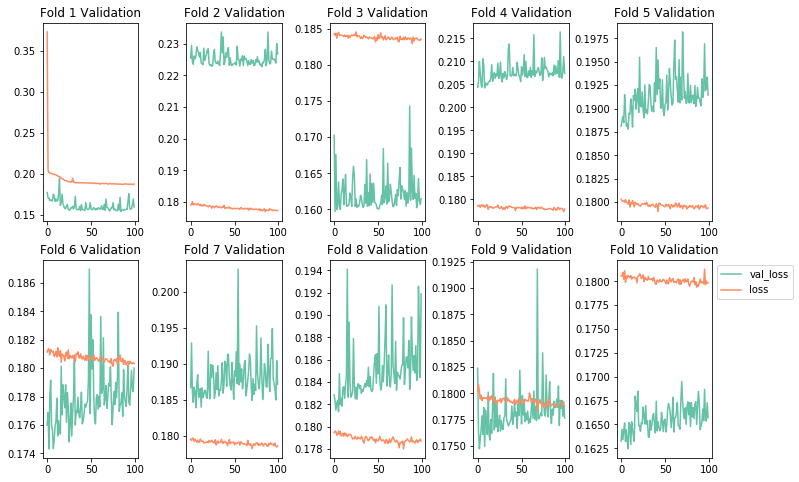

In [503]:
now = datetime.datetime.now()
k_folds(X_train, y_train, model, k=10)
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

In [504]:
# Your code here; try some methods to overfit your network
# ⏰ This cell may take several mintes to run
now = datetime.datetime.now()
input_dim = X_train.shape[1]
np.random.seed(123)
model = Sequential()
model.add(Dense(8,input_dim=input_dim,  kernel_initializer='normal', activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))

model.compile(optimizer='sgd' ,loss='mse',metrics=['mse'])

elapsed = later - now
print('Time Elapsed:', elapsed)


Time Elapsed: -1 day, 23:33:44.420785


3190/3190 [==============================] - 0s 15us/step
Mean Validation Score: 0.18285639222793174
Standard Deviation of Validation Scores: 0.01506439065158814
Time Elapsed: 0:22:04.784660


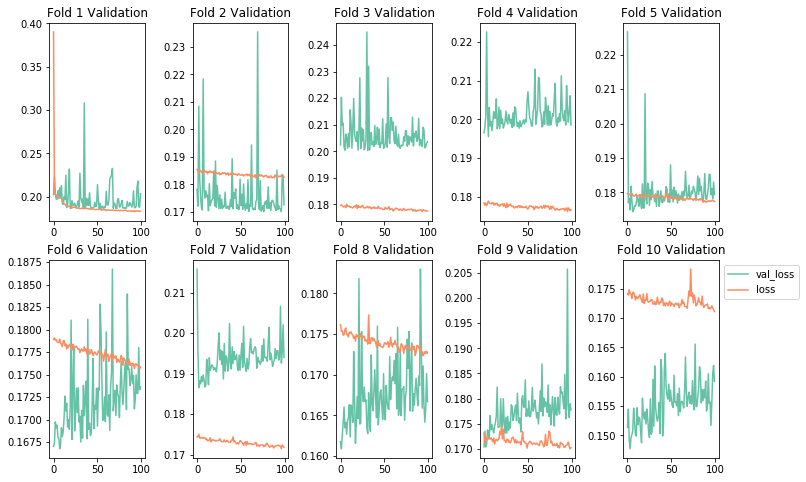

In [505]:
now = datetime.datetime.now()
k_folds(X_train, y_train, model)
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

In [506]:
# Your code here; try some methods to overfit your network
# ⏰ This cell may take several mintes to run
now = datetime.datetime.now()
input_dim = X_train.shape[1]
np.random.seed(123)
model = Sequential()
model.add(Dense(8,input_dim=input_dim,  kernel_initializer='normal', activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))

model.compile(optimizer='sgd' ,loss='mse',metrics=['mse'])

elapsed = later - now
print('Time Elapsed:', elapsed)

Time Elapsed: -1 day, 23:59:58.175445


3190/3190 [==============================] - 0s 26us/step
Mean Validation Score: 0.18312084838464412
Standard Deviation of Validation Scores: 0.012858073346830593
Time Elapsed: 0:50:21.799603


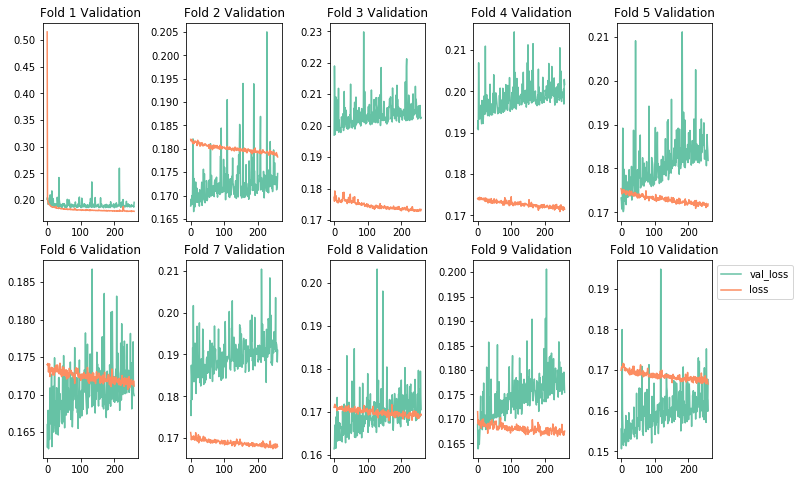

In [507]:
now = datetime.datetime.now()
k_folds(X_train, y_train, model, n_epochs=260)
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

## Regularizing the Model to Achieve Balance  

Now that you have a powerful model (albeit an overfit one), we can now increase the generalization of the model by using some of the regularization techniques we discussed. Some options you have to try include:  
* Adding dropout
* Adding L1/L2 regularization
* Altering the layer architecture (add or remove layers similar to above)  

This process will be constrained by time and resources. Be sure to test at least 2 different methodologies, such as dropout and L2 regularization. If you have the time, feel free to continue experimenting.

Notes: 

In [509]:
# Your code here; try some regularization or other methods to tune your network
# ⏰ This cell may take several mintes to run

input_dim = X_train.shape[1]
np.random.seed(123)
model = Sequential()

model.add(Dense(8,input_dim=input_dim,  kernel_initializer='normal', activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(20, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(15, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(15, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer='sgd' ,loss='mse',metrics=['mse'])


3190/3190 [==============================] - 0s 20us/step
Mean Validation Score: 0.6154726297264548
Standard Deviation of Validation Scores: 0.0619602044588434
Time Elapsed: 1:11:58.228531


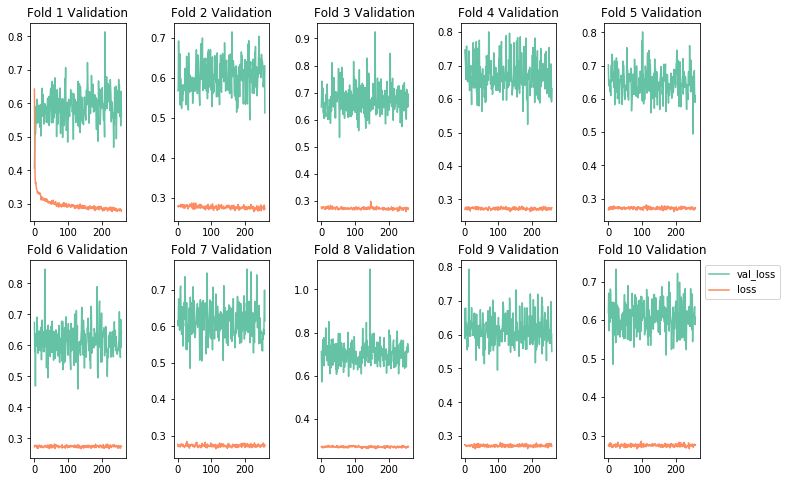

In [510]:
now = datetime.datetime.now()

k_folds(X_train, y_train, model, n_epochs=260)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3190/3190 [==============================] - 0s 17us/step
Mean Validation Score: 0.2084016211011217
Standard Deviation of Validation Scores: 0.018996194695978786
Time Elapsed: 1:06:43.409230


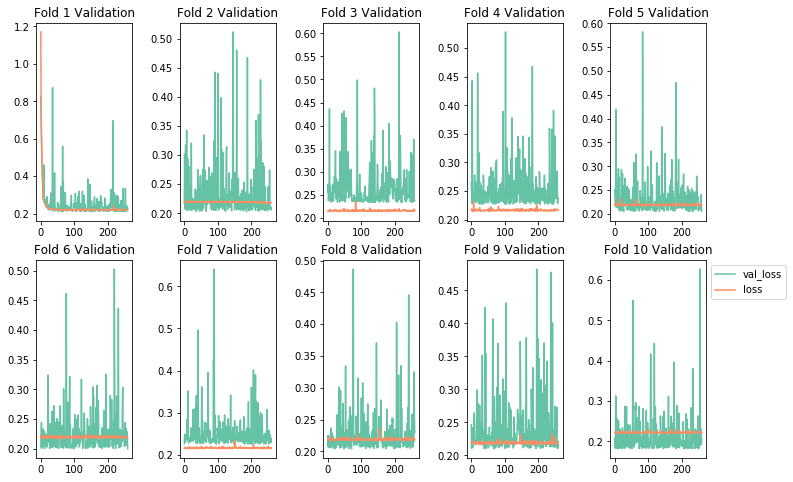

In [512]:
# Your code here; try some regularization or other methods to tune your network
# ⏰ This cell may take several mintes to run
import seaborn as sns
import matplotlib.pyplot as plt
from keras import regularizers
from keras import layers

input_dim = X_train.shape[1]
np.random.seed(123)
model = Sequential()
model.add(Dense(8,input_dim=input_dim,  kernel_initializer='normal',kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model.add(Dense(15, activation='relu',kernel_regularizer=regularizers.l1(0.005)))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer='sgd' ,loss='mse',metrics=['mse'])


now = datetime.datetime.now()

k_folds(X_train, y_train, model, n_epochs=260)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)


3190/3190 [==============================] - 0s 43us/step
Mean Validation Score: 0.20396805194523884
Standard Deviation of Validation Scores: 0.018214105932282468
Time Elapsed: 0:52:30.338606


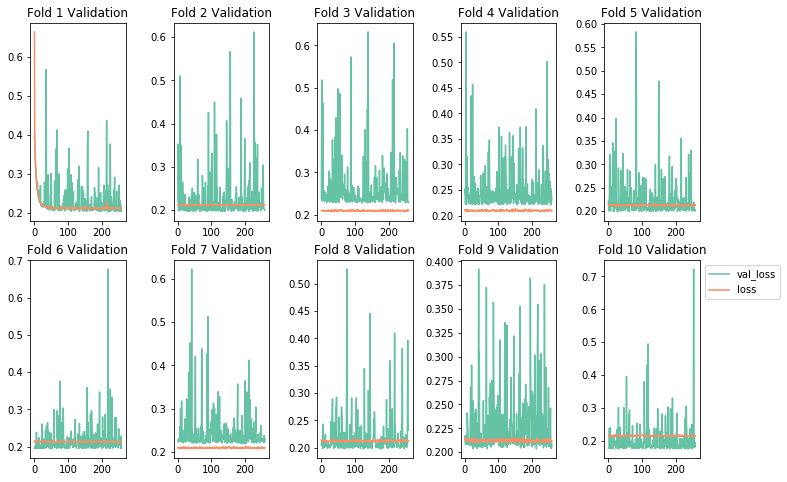

In [513]:
# Your code here; try some regularization or other methods to tune your network
# ⏰ This cell may take several mintes to run
input_dim = X_train.shape[1]
np.random.seed(123)
model = Sequential()
model.add(Dense(8,input_dim=input_dim,  kernel_initializer='normal',kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(15, activation='relu',kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer='sgd' ,loss='mse',metrics=['mse'])


now = datetime.datetime.now()

k_folds(X_train, y_train, model, n_epochs=260)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

In [30]:
# Your code here; try some regularization or other methods to tune your network
# l2 regularization , early stopping, dropout layers are applied for optimization
# ⏰ This cell may take several mintes to run
from keras.layers import Dense, Dropout
import seaborn as sns
import matplotlib.pyplot as plt
from keras import regularizers
from keras import layers

input_dim = X_train.shape[1]
np.random.seed(123)
model = Sequential()
model.add(Dense(8,input_dim=input_dim,  kernel_initializer='normal',kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dropout(0.3))
model.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dropout(0.3))
model.add(Dense(15, activation='relu',kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer='sgd' ,loss='mse',metrics=['mse'])


now = datetime.datetime.now()

k_folds(X_train, y_train, model, n_epochs=100)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3190/3190 [==============================] - 0s 23us/step
Mean Validation Score: 0.48340441695042025
Standard Deviation of Validation Scores: 0.06766799307744532
Time Elapsed: 0:29:29.604924


## Final Evaluation

Now that you have selected a network architecture, tested various regularization procedures and tuned hyperparameters via a validation methodology, it is time to evaluate your finalized model once and for all. Fit the model using all of the training and validation data using the architecture and hyperparameters that were most effective in your experiments above. Afterwards, measure the overall performance on the hold-out test data which has been left untouched (and hasn't leaked any data into the modeling process)!

In [32]:
# Your code here; final model training on entire training set followed by evaluation on hold-out data
# ⏰ This cell may take several mintes to run
# Your code here; final model training on entire training set followed by evaluation on hold-out data
# Based on our model runs above, it appears that using  L2 Regularization and Early Stopping
# improves our variance 10 fold in exchange for a slight increase in MSE
# As such, we will choose this as our final model in hopes that the model will have improved generalization
now = datetime.datetime.now()

input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

hist =  hist = model.fit(X_train, y_train, batch_size=32, epochs=75)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

model.evaluate(X_test, y_test)


Epoch 1/75
31901/31901 [==============================] - 2s 51us/step - loss: 0.7203 - mse: 0.5879
Epoch 2/75
31901/31901 [==============================] - 2s 49us/step - loss: 0.3170 - mse: 0.2031
Epoch 3/75
31901/31901 [==============================] - 2s 49us/step - loss: 0.2950 - mse: 0.1999
Epoch 4/75
31901/31901 [==============================] - 2s 54us/step - loss: 0.2787 - mse: 0.1991: 0s - loss: 0.281
Epoch 5/75
31901/31901 [==============================] - 2s 51us/step - loss: 0.2650 - mse: 0.1980
Epoch 6/75
31901/31901 [==============================] - 2s 58us/step - loss: 0.2546 - mse: 0.1979
Epoch 7/75
31901/31901 [==============================] - 2s 57us/step - loss: 0.2454 - mse: 0.1971
Epoch 8/75
31901/31901 [==============================] - 2s 52us/step - loss: 0.2389 - mse: 0.1975
Epoch 9/75
31901/31901 [==============================] - 2s 47us/step - loss: 0.2322 - mse: 0.1963
Epoch 10/75
31901/31901 [==============================] - 1s 41us/step - loss: 0.

[0.20036909341789713, 0.19340471923351288]

## Summary

In this lab, you investigated some data from *The Lending Club* in a complete data science pipeline regarding neural networks. You began with reserving a hold-out set for testing which never was touched during the modeling phase. From there, you implemented a k-fold cross validation methodology in order to assess an initial baseline model and various regularization methods. From here, you'll begin to investigate other neural network architectures such as CNNs.